+ Dropping verb variations from pos/neg dictionaries to make stemming point more relevant?

In [1]:
# Install necessary packages
# !pip install flashtext
# !pip install contractions
# !pip install --upgrade spacy==2.2.4
# !pip install gdown

In [2]:
# Restart RUNTIME after installing packages!

In [3]:
import pandas as pd
import numpy as np
import gdown
import random
import string
import re
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import contractions

import sys
sys.path.append('../pymodules')
import preprocessing_class as pc
import preprocess_data

import unicodedata
import spacy
nlp_standard = spacy.load('en_core_web_sm')

import nltk
from nltk import SnowballStemmer
stemmer = SnowballStemmer(language='english')

In [4]:
# define paths and seed
seed = 92
data_path = "./"

In [5]:
# define dictionary with paths to data in Google Drive
data_url_dict = {"mpc_minutes": ("https://drive.google.com/uc?id=1k086m12gBHKuVMPv4GUD1aB_kZOZpznR", "txt"),
                "ons_quarterly_gdp": ("https://drive.google.com/uc?id=1_8JwCNUsq9wnPiTDmcJ2xrWklGGDFbQD", "csv"),
                "gdp_sentiment": ("https://drive.google.com/uc?id=1DrJpCsLBfJMPQ6O6wBZKeb3haDD0EaSY", "csv")}

In [6]:
# download each file in the dictionary
for file_name, attributes in data_url_dict.items():
    url = attributes[0]
    extension = attributes[1]
    gdown.download(url, f"{file_name}.{extension}", quiet=False) 

Downloading...
From: https://drive.google.com/uc?id=1k086m12gBHKuVMPv4GUD1aB_kZOZpznR
To: /Users/llaurabat/Dropbox/BGSE_work/AR/ARE_text_algorithms_economics/notebooks/mpc_minutes.txt
100%|██████████| 7.36M/7.36M [00:04<00:00, 1.77MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_8JwCNUsq9wnPiTDmcJ2xrWklGGDFbQD
To: /Users/llaurabat/Dropbox/BGSE_work/AR/ARE_text_algorithms_economics/notebooks/ons_quarterly_gdp.csv
100%|██████████| 3.33k/3.33k [00:00<00:00, 11.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1DrJpCsLBfJMPQ6O6wBZKeb3haDD0EaSY
To: /Users/llaurabat/Dropbox/BGSE_work/AR/ARE_text_algorithms_economics/notebooks/gdp_sentiment.csv
100%|██████████| 2.36k/2.36k [00:00<00:00, 6.74MB/s]


# Text preprocessing and dictionary methods

This notebook makes use of our RawDocs class to illustrate a preprocessing pipeline for text data. Indeed, raw text typically needs to be cleaned before it can serve as input for a statistical model. 

As an example, we could want to split contractions, remove stopwords or remove punctuation. These steps can help a statistical model to only learn from terms that have a relevant meaning. 

We might also want to replace a term or a set of terms with another token. For instance, this operation could allow us to replace phrases (e.g. bigrams, trigrams) with single tokens.

Another common practice in text preprocessing is that of stemming (remove affixes and replace with root) or lemmatizing (replace with dictionary form i.e. lemma). These procedures bring words with the same root meaning back to a single token.

Finally, we might want to remove very frequent or infrequent words, and transform the data into a document-term matrix that can be fed into models that follow a bag-of-words approach.

# 1. Load data

This tutorial uses text data from Bank of England minutes. As a first step, we inspect the data. We observe that we have a total number of 7277 strings of data (hereafter "documents") that are produced monthly for 18 years (06/1997 to 10/2014). The average length of a document is of 161 words.

In [7]:
data = pd.read_csv(data_path + 'mpc_minutes.txt', delimiter='\t', header=0, names=['date', 'minutes'])
print(data.shape)
data.head()

(7277, 2)


,date,minutes
0,199706,1 Sections I to V of this minute summarise t...
1,199706,The 12-month growth rate of notes and coins ...
2,199706,"Broad money, too, decelerated in April: its ..."
3,199706,Lending growth continued at around 9% in ...
4,199706,Lending to individuals remained robust in...


In [8]:
# turn date into date format and create quarter column
data['date'] = pd.to_datetime(data.date, format='%Y%m')
data['year'] = data.date.dt.year.astype(int)
data['quarter'] = data.date.dt.quarter.astype(int)
data['date'] = data['date'].dt.strftime('%Y%m')
data.head()

,date,minutes,year,quarter
0,199706,1 Sections I to V of this minute summarise t...,1997,2
1,199706,The 12-month growth rate of notes and coins ...,1997,2
2,199706,"Broad money, too, decelerated in April: its ...",1997,2
3,199706,Lending growth continued at around 9% in ...,1997,2
4,199706,Lending to individuals remained robust in...,1997,2


In [9]:
data['length'] = data.minutes.apply(lambda x: len(x.split()))
print(f'average document length: {np.round(np.mean(data.length),0)} words')

average document length: 161.0 words


In [10]:
print('n. months:',len(data.date.unique()))
print('n. years:',len(data.year.unique()))
data.date.unique()

n. months: 209
n. years: 18


array(['199706', '199707', '199708', '199709', '199710', '199711',
       '199712', '199801', '199802', '199803', '199804', '199805',
       '199806', '199807', '199808', '199809', '199810', '199811',
       '199812', '199901', '199902', '199903', '199904', '199905',
       '199906', '199907', '199908', '199909', '199910', '199911',
       '199912', '200001', '200002', '200003', '200004', '200005',
       '200006', '200007', '200008', '200009', '200010', '200011',
       '200012', '200101', '200102', '200103', '200104', '200105',
       '200106', '200107', '200108', '200109', '200110', '200111',
       '200112', '200201', '200202', '200203', '200204', '200205',
       '200206', '200207', '200208', '200209', '200210', '200211',
       '200212', '200301', '200302', '200303', '200304', '200305',
       '200306', '200307', '200308', '200309', '200310', '200311',
       '200312', '200401', '200402', '200403', '200404', '200405',
       '200406', '200407', '200408', '200409', '200410', '2004

#  2. Preprocessing using the RawDocs class

## 2.1 Initialize class

We instantiate the ```RawDocs``` class by passing a pandas series containing the raw documents. In the initialization, we provide parameters that will define the way in which the text will be cleaned and tokenized at a later stage. 

We can as well set a list of stopwords that will be saved into the "stopwords" attribute. We can go for the "long" list (retrieved from http://snowball.tartarus.org/algorithms/english/stop.txt) or the "short" list (a subsample defined as in Hansen, McMahon, and Prat (2014)). We can also pass a customized list, or no list at all (we are always free to add it later on by modifying the ```stopwords``` attribute).

By setting the ```contraction_split``` argument to ```True```, we will also expand English contractions to their extended form (e.g. "doesn't" to "does not"). Finally, we can pass a tokenization pattern that will override the default tokenization algorithm with a user-defined tokenization routine based on a specific regular expression. In our case, we pass a regex that ensures e.g. not to tokenize over hyphens, currency or percentage signs. 

In [11]:
pattern = r'''
          (?x)                # set flag to allow verbose regexps (to separate logical sections of pattern and add comments)
          \w+(?:-\w+)*        # word characters with internal hyphens
          | [][.,;"'?():-_`]  # preserve punctuation as separate tokens
          '''

In [12]:
prep = pc.RawDocs(data.minutes, 
                  stopwords='long', 
                  contraction_split=True, 
                  tokenization_pattern=pattern)

At this stage, we have not performed any preprocessing yet. We are free to access raw documents via the ```docs``` attribute.

In [13]:
# notice that the documents from the object are identical to the ones from the pandas series
i = 20
print("Document from the pandas series:\n", data.loc[i, "minutes"])
print("\n-------------------------\n")
print("Document from preprocessing object:\n", prep.docs[i])

Document from the pandas series:
   In the UK, there was a continuing contrast between goods and services inflation. Goods inflation fell further in April, to 1.9%, compared with 2.1% in March and over 3% in late 1996. Services inflation, which had been as low as 2% in Spring 1996, was unchanged at 3.2% between March and April this year. The April figure for services inflation was particularly significant because approaching half of services prices are recorded in a survey held in the first month of each quarter. Within the category of services, utility and rent inflation fell between March and April, while other services inflation continued to rise.

-------------------------

Document from preprocessing object:
   In the UK, there was a continuing contrast between goods and services inflation. Goods inflation fell further in April, to 1.9%, compared with 2.1% in March and over 3% in late 1996. Services inflation, which had been as low as 2% in Spring 1996, was unchanged at 3.2% betwe

## 2.2 Lower-case, split contractions

In the previous notebook, we have used Python built-in functions to lower-case the text. We can achieve the same via the ```basic_cleaning()``` method, that allows as well for contractions expansion.

In [14]:
# lower-case text, expand contractions
prep.basic_cleaning()

In [15]:
# explore an example after the basic cleaning has been applied
i = 10
print(data.minutes[i])
print()
print(prep.docs[i])

  There was as yet no clear downtrend in net exports. Exports to non-EU countries had risen sharply: the USA had grown very fast in Q1, but it was expected by US commentators to slow down spontaneously. Net exports to EU countries had been resilient. GDP growth in France and Germany (though not Italy) had picked up to just below trend, but domestic demand growth in those countries had been subdued.

  there was as yet no clear downtrend in net exports. exports to non-eu countries had risen sharply: the usa had grown very fast in q1, but it was expected by us commentators to slow down spontaneously. net exports to eu countries had been resilient. gdp growth in france and germany (though not italy) had picked up to just below trend, but domestic demand growth in those countries had been subdued.


## 2.3 Replace phrases with single token

The ```phrase_replace``` method is an extremely convenient method of the RawDocs class. In particular, it will replace the keys with the values of a user-defined "replace_dict". It can prove useful if for instance we want to replace specific phrases with a single token. Let's give it a try:

In [16]:
replacing_dict = {'financial intermediation':'financial-intermediation',
                  'interest rate':'interest-rate'}

In [17]:
prep.phrase_replace(replace_dict=replacing_dict)

In [18]:
i = 3
print(data.minutes[i])
print()
print(prep.docs[i])

     Lending growth continued at around 9% in April. Borrowing by ICCs, which had decelerated in Q1, picked up again in April, and unused credit facilities (mainly to ICCs) continued to rise quickly (the 12 month increase was about 13% in April). Interest rate spreads seemed to have narrowed for ICCs and OFIs in Q1, which suggested that banks had become more willing to lend, perhaps in response to competition from other forms of financial intermediation.

     lending growth continued at around 9% in april. borrowing by iccs, which had decelerated in q1, picked up again in april, and unused credit facilities (mainly to iccs) continued to rise quickly (the 12 month increase was about 13% in april). interest-rate spreads seemed to have narrowed for iccs and ofis in q1, which suggested that banks had become more willing to lend, perhaps in response to competition from other forms of financial-intermediation.


## 2.4 Tokenize

We will now use the ```tokenize_text()``` method to split documents into tokens, using the custom pattern we provided in the initialisation. It is very important that we use a tokenization pattern that does not split over hyphens, since we have used the hyphen when replacing phrases earlier. After applying this method, our preprocessing object (```prep```) will get a new attribute that we can access: ```.tokens```.

In [19]:
# now we can split the documents into tokens
prep.tokenize_text()

Below, we show a random document and its tokenized version. As we can see, text was tokenized in such a way that expressions such as "non-EU" were kept as a single token. Notice also that punctuation symbols were preserved.

In [20]:
i = 10
print(data.minutes[i])
print()
print(prep.tokens[i])

  There was as yet no clear downtrend in net exports. Exports to non-EU countries had risen sharply: the USA had grown very fast in Q1, but it was expected by US commentators to slow down spontaneously. Net exports to EU countries had been resilient. GDP growth in France and Germany (though not Italy) had picked up to just below trend, but domestic demand growth in those countries had been subdued.

['there', 'was', 'as', 'yet', 'no', 'clear', 'downtrend', 'in', 'net', 'exports', '.', 'exports', 'to', 'non-eu', 'countries', 'had', 'risen', 'sharply', ':', 'the', 'usa', 'had', 'grown', 'very', 'fast', 'in', 'q1', ',', 'but', 'it', 'was', 'expected', 'by', 'us', 'commentators', 'to', 'slow', 'down', 'spontaneously', '.', 'net', 'exports', 'to', 'eu', 'countries', 'had', 'been', 'resilient', '.', 'gdp', 'growth', 'in', 'france', 'and', 'germany', '(', 'though', 'not', 'italy', ')', 'had', 'picked', 'up', 'to', 'just', 'below', 'trend', ',', 'but', 'domestic', 'demand', 'growth', 'in', 'th

At this point, tokens could be ready to use for some specific aims. For instance, one might want to count instances of specific terms, including punctuation. However, more often one wants to proceed with heavier preprocessing, for which other methods of the RawDocs class can prove useful.

## 2.5 Remove non-ASCII symbols, punctuation, numbers, short tokens

The ```token_clean()``` method iterates over tokens and removes elements that we might consider unnecessary or impairing our analysis.

The method automatically removes non-ASCII characters. In addition, we can remove punctuation, numbers and tokens with a number of characters lower than or equal to "length". The function removes by default the punctuation included in the string package:

In [21]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

However, we are free to pass a customised punctuation string. Here, we pass the string above excluding hypens.

In [22]:
punctuation = string.punctuation
punctuation = punctuation.replace("-", "")
punctuation

'!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'

In [23]:
prep.token_clean(length=2,                # remove tokens with less than this number of characters 
                 punctuation=punctuation, # remove custom list of punctuation characters
                 numbers=True)            # remove numbers

Let's now look at a document. As we can see, numbers and very short tokens were removed, as well as punctuation, but excluding e.g. hypens.

In [24]:
i = 10
print(data.minutes[i])
print()
print(prep.tokens[i])

  There was as yet no clear downtrend in net exports. Exports to non-EU countries had risen sharply: the USA had grown very fast in Q1, but it was expected by US commentators to slow down spontaneously. Net exports to EU countries had been resilient. GDP growth in France and Germany (though not Italy) had picked up to just below trend, but domestic demand growth in those countries had been subdued.

['there', 'was', 'yet', 'clear', 'downtrend', 'net', 'exports', 'exports', 'non-eu', 'countries', 'had', 'risen', 'sharply', 'the', 'usa', 'had', 'grown', 'very', 'fast', 'but', 'was', 'expected', 'commentators', 'slow', 'down', 'spontaneously', 'net', 'exports', 'countries', 'had', 'been', 'resilient', 'gdp', 'growth', 'france', 'and', 'germany', 'though', 'not', 'italy', 'had', 'picked', 'just', 'below', 'trend', 'but', 'domestic', 'demand', 'growth', 'those', 'countries', 'had', 'been', 'subdued']


## 2.6 Remove stopwords

The ```remove_stopwords()``` method allows to remove tokens included in the ```stopwords``` attribute. We went for the "long" stopwords list, that is printed below.

In [25]:
print(sorted(prep.stopwords))

['a', 'about', 'above', 'after', 'again', 'against', 'all', 'also', 'am', 'an', 'and', 'another', 'any', 'are', 'as', 'at', 'back', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'could', 'did', 'do', 'does', 'doing', 'down', 'during', 'each', 'even', 'ever', 'every', 'few', 'first', 'five', 'for', 'four', 'from', 'further', 'get', 'go', 'goes', 'had', 'has', 'have', 'having', 'he', 'her', 'here', 'hers', 'herself', 'high', 'him', 'himself', 'his', 'how', 'however', 'i', 'if', 'in', 'into', 'is', 'it', 'its', 'itself', 'just', 'least', 'less', 'like', 'long', 'made', 'make', 'many', 'me', 'more', 'most', 'my', 'myself', 'never', 'new', 'no', 'nor', 'not', 'now', 'of', 'off', 'old', 'on', 'once', 'one', 'only', 'or', 'other', 'ought', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 'put', 'said', 'same', 'say', 'says', 'second', 'see', 'seen', 'she', 'should', 'since', 'so', 'some', 'still', 'such', 'take', 'than', 'that', 'the', 'their', 'theirs'

In [26]:
prep.stopword_remove('tokens')

As we can see, after applying the ```stopwords_remove()``` method, tokens like "just" or "below" have been dropped.

In [27]:
i = 10
print(data.minutes[i])
print()
print(prep.tokens[i])

  There was as yet no clear downtrend in net exports. Exports to non-EU countries had risen sharply: the USA had grown very fast in Q1, but it was expected by US commentators to slow down spontaneously. Net exports to EU countries had been resilient. GDP growth in France and Germany (though not Italy) had picked up to just below trend, but domestic demand growth in those countries had been subdued.

['yet', 'clear', 'downtrend', 'net', 'exports', 'exports', 'non-eu', 'countries', 'risen', 'sharply', 'usa', 'grown', 'fast', 'expected', 'commentators', 'slow', 'spontaneously', 'net', 'exports', 'countries', 'resilient', 'gdp', 'growth', 'france', 'germany', 'though', 'italy', 'picked', 'trend', 'domestic', 'demand', 'growth', 'countries', 'subdued']


## 2.7 Stem or lemmatize

As a next step, one might attempt to group together words that are grammatically different but thematically identical. For example, it could be reasonable to keep words such as "obligations", "obligation" and  "oblige" under a single token. Ultimately, these three words denote the same concept, and so we might want them to share the same symbol. 

The two most popular techniques to achieve this goal are stemming and lemmatization.  Stemming removes affixes and replaces each word with its root, while lemmatization replaces words with their dictionary form i.e. lemma. 

The RawDocs class allows both stemming (via nltk Snowball stemmer) and lemmatization (via spaCy lemmatizer). Below, we use both techniques and look at the different results on a specific document. Stems and lemmas are stored in the "stems" and "lemmas" attributes respectively.

In [28]:
%%time
prep.stem()

CPU times: user 6.5 s, sys: 16.7 ms, total: 6.52 s
Wall time: 6.53 s


In [29]:
%%time
prep.lemmatize()

CPU times: user 1min 10s, sys: 3.96 s, total: 1min 14s
Wall time: 1min 15s


In [30]:
i = 3
print(prep.tokens[i])
print()
print(prep.stems[i])
print()
print(prep.lemmas[i])

['lending', 'growth', 'continued', 'around', 'april', 'borrowing', 'iccs', 'decelerated', 'picked', 'april', 'unused', 'credit', 'facilities', 'mainly', 'iccs', 'continued', 'rise', 'quickly', 'month', 'increase', 'april', 'interest-rate', 'spreads', 'seemed', 'narrowed', 'iccs', 'ofis', 'suggested', 'banks', 'become', 'willing', 'lend', 'perhaps', 'response', 'competition', 'forms', 'financial-intermediation']

['lend', 'growth', 'continu', 'around', 'april', 'borrow', 'icc', 'deceler', 'pick', 'april', 'unus', 'credit', 'facil', 'main', 'icc', 'continu', 'rise', 'quick', 'month', 'increas', 'april', 'interest-rate', 'spread', 'seem', 'narrow', 'icc', 'ofi', 'suggest', 'bank', 'becom', 'will', 'lend', 'perhap', 'respons', 'competit', 'form', 'financial-intermediation']

['lending', 'growth', 'continue', 'around', 'april', 'borrowing', 'iccs', 'decelerate', 'pick', 'april', 'unused', 'credit', 'facility', 'mainly', 'iccs', 'continue', 'rise', 'quickly', 'month', 'increase', 'april', 'i

## 2.8 Term ranking 

Finally, one might want to drop very frequent terms, as they could be regarded as corpus-specific stopwords that do not add up much value. Similarly, one might want to drop very rare terms, considering that not much can be learnt from such infrequent items. 

To explore these ideas, the ```get_term_ranking()``` method comes in handy. It allows to rank items (either tokens, stems or lemmas) according to pure document frequency (df) or term frequency inverse document frequency (tf-idf) - where  high weight is given to terms that appear frequently in the entire dataset, but in relatively few documents. In particular, the tf-idf score for term $v$ is computed according to the formula below:

\begin{equation}
tfidf_v = (1+log(tf_v)) (log \frac{N}{df_v+1})
\end{equation}

Results are stored in the ```df_ranking``` and ```tfidf_ranking``` attributes respectively, and come as a list of tuples of the form (score, term, ranking position). Let's now look at the top ranked tokens in terms of document frequency:

In [31]:
prep.get_term_ranking(items='tokens',score_type='df')
prep.df_ranking['tokens'][:10]

[(3431.0, 'growth', 0),
 (3059.0, 'inflation', 1),
 (2532.0, 'rate', 2),
 (2530.0, 'committee', 3),
 (2388.0, 'prices', 4),
 (2266.0, 'market', 5),
 (1936.0, 'demand', 6),
 (1905.0, 'remained', 7),
 (1875.0, 'month', 8),
 (1853.0, 'output', 9)]

As we can see, the token "growth" ranks first, with a document frequency of 3431 out of 7277 (i.e. "growth" is present in around 47% of the documents), and "rate" and "inflation" come right after.

Let's now look at the top ranked tokens in terms of tf-df:

In [32]:
prep.get_term_ranking(items='tokens',score_type='tfidf')
prep.tfidf_ranking['tokens'][:10]

[(29.825243257254172, 'nfc', 0),
 (29.417855025455637, 'ips', 1),
 (29.394055447843666, 'securitisations', 2),
 (28.20096850526625, 'surveya', 3),
 (28.09284413266011, 'pnfcsa', 4),
 (27.928971035400984, 'attacks', 5),
 (27.89033249950207, 'bcc', 6),
 (27.731835312191592, 'egarding', 7),
 (27.616652544786927, 'working-age', 8),
 (27.47589968820303, 'deliveries', 9)]

As we can see, the two methods do not agree. Indeed, tf-idf weights more those terms that are frequent, but in relatively few documents. 

If instead we look at the bottom-ranked terms, we see that the two methods agree way more:

In [33]:
prep.df_ranking['tokens'][-10:]

[(1.0, 'yardstick', 538),
 (1.0, 'year-', 538),
 (1.0, 'yesa', 538),
 (1.0, 'yield-curve', 538),
 (1.0, 'ynchronised', 538),
 (1.0, 'york', 538),
 (1.0, 'yorkshire', 538),
 (1.0, 'ypically', 538),
 (1.0, 'yukos', 538),
 (1.0, 'zero-interesta', 538)]

In [34]:
prep.tfidf_ranking['tokens'][-10:]

[(8.199326787787141, 'year-', 1630),
 (8.199326787787141, 'yesa', 1630),
 (8.199326787787141, 'yield-curve', 1630),
 (8.199326787787141, 'ynchronised', 1630),
 (8.199326787787141, 'york', 1630),
 (8.199326787787141, 'yorkshire', 1630),
 (8.199326787787141, 'ypically', 1630),
 (8.199326787787141, 'yukos', 1630),
 (8.199326787787141, 'zero-interesta', 1630),
 (7.757875162555764, 'growth', 1631)]

This is typical, as terms with an extremely small term frequency usually have a relatively small tf-idf even if logically they appear in very few documents, as the first term in the tf-idf formula tends to prevail. Obviously, they also have a low document frequency score.

Let's now inspect the behavior of df and tf-idf ranking. As we can see, document frequency decays very fast, while tf-idf decreases at a slower pace.

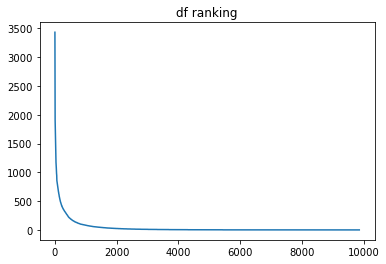

In [35]:
plt.plot([x[0] for x in prep.df_ranking['tokens']])
plt.title('df ranking')
plt.show()

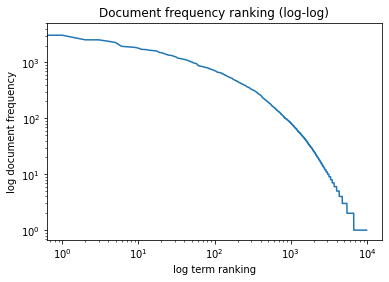

In [36]:
# we can use a log-log scale to observe more clearly the power-law distribution (Zipf's law)

plt.loglog([x[0] for x in prep.df_ranking['tokens']])
plt.title('Document frequency ranking (log-log)')
plt.ylabel("log document frequency")
plt.xlabel("log term ranking")
plt.show()

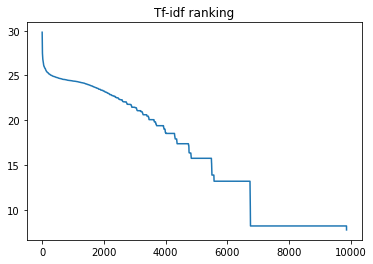

In [37]:
plt.plot([x[0] for x in prep.tfidf_ranking['tokens']])
plt.title('Tf-idf ranking')
plt.show()

## 2.9 Remove terms and vectorize

The ```dt_matrix_create()``` method allows us to vectorize documents according to either document frequency or tf-idf. Moreover, the function allows to drop terms with high or low score values.

For instance, picking document frequency as a criterion, we observe that around 3000 terms only appear 3 times across the whole corpus. We might decide to remove them and lighten our subsequent analysis.

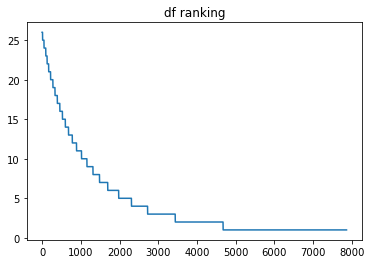

In [38]:
plt.plot([x[0] for x in prep.df_ranking['tokens'][2000:]])
plt.title('df ranking')
plt.show()

In [39]:
print(len(prep.df_ranking['tokens']))
prep.df_ranking['tokens'][-10:]

9863


[(1.0, 'yardstick', 538),
 (1.0, 'year-', 538),
 (1.0, 'yesa', 538),
 (1.0, 'yield-curve', 538),
 (1.0, 'ynchronised', 538),
 (1.0, 'york', 538),
 (1.0, 'yorkshire', 538),
 (1.0, 'ypically', 538),
 (1.0, 'yukos', 538),
 (1.0, 'zero-interesta', 538)]

In [40]:
prep.dt_matrix_create(items='tokens', score_type='df', min_df=4)

We can now observe that the bottom-ranked terms have changed and now have a minimum document frequency of 4.

In [41]:
prep.get_term_ranking(items='tokens',score_type='df')
print(len(prep.df_ranking['tokens']))
prep.df_ranking['tokens'][-10:]

4723


[(4.0, 'welfare-to-work', 535),
 (4.0, 'wheat', 535),
 (4.0, 'window', 535),
 (4.0, 'wished', 535),
 (4.0, 'withdrawals', 535),
 (4.0, 'workforces', 535),
 (4.0, 'working-day', 535),
 (4.0, 'wrongly', 535),
 (4.0, 'yielding', 535),
 (4.0, 'zone', 535)]

We can also observe that a document term frequency matrix has been produced:

In [42]:
print(prep.df_matrix['tokens'].shape)
prep.df_matrix['tokens']

(7277, 4723)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 2., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

This object, eventually together with the vocabulary stored under "vocabulary", can be used as input to many bag-of-words text analysis algorithms such as dictionary methods, word2vec, Latent Semantic Analysis (LSA) or Linear Dirichlet Allocation (LDA).

## 2.10 Vectorization on stems/lemmas

In sections 2.8 and 2.9, we have focused on tokens. Depending on the object of our analysis, we can easily perform the same transformations on stems or lemmas.

In [43]:
prep.dt_matrix_create(items='lemmas', score_type='df', min_df=1)
print(prep.df_matrix['lemmas'].shape)
prep.df_matrix['lemmas']

(7277, 8090)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [44]:
prep.dt_matrix_create(items='stems', score_type='df', min_df=1)
print(prep.df_matrix['stems'].shape)
prep.df_matrix['stems']

(7277, 6540)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# 3. Sentiment analysis after preprocessing

We now want to see whether a more sophisticated preprocessing leads to a sentiment index that is more correlated to GDP, when comparing with the index we obtained in Notebook 1.  

That is, we will still build a document sentiment index based on the count of words having a "positive" or "negative" sentiment, and compare such an index to UK GDP. However, we hope that the enhanced preprocessing will lead to a better dictionary search, and therefore an improved sentiment index.

We choose stems as our level of analysis. For dictionary searches to be successful, we need sentiment words to be cleaned and stemmed the same way as the main text.

In [45]:
pos_words = ['accelerate','accelerated','accelerates','accelerating','expand','expanded','expanding','expands',
             'fast','faster','fastest','gain','gained','gaining','gains','high','higher','highest','increase',
             'increased','increases','increasing','strong','stronger','strongest']

In [46]:
neg_words = ['contract','contracted','contracting','contracts','decelerate','decelerated','decelerates',
             'decelerating','decrease','decreased','decreases','decreasing','lose','losing','loss','losses',
             'lost','low','lower','lowest','slow','slower','slowest','weak','weaker','weakest']

In [47]:
pos_clean = pc.RawDocs([' '.join(pos_words)], stopwords='long', contraction_split=True, tokenization_pattern=pattern)
pos_clean.basic_cleaning()
pos_clean.tokenize_text()
pos_clean.token_clean(length=2,punctuation=punctuation, numbers=True)
pos_clean.stem() 
pos_stems = pos_clean.stems[0]
print(pos_stems) 

neg_clean = pc.RawDocs([' '.join(neg_words)], stopwords='long', contraction_split=True, tokenization_pattern=pattern)
neg_clean.basic_cleaning()
neg_clean.tokenize_text()
neg_clean.token_clean(length=2,punctuation=punctuation, numbers=True)
neg_clean.stem() 
neg_stems = neg_clean.stems[0]
print(neg_stems)  

['acceler', 'acceler', 'acceler', 'acceler', 'expand', 'expand', 'expand', 'expand', 'fast', 'faster', 'fastest', 'gain', 'gain', 'gain', 'gain', 'high', 'higher', 'highest', 'increas', 'increas', 'increas', 'increas', 'strong', 'stronger', 'strongest']
['contract', 'contract', 'contract', 'contract', 'deceler', 'deceler', 'deceler', 'deceler', 'decreas', 'decreas', 'decreas', 'decreas', 'lose', 'lose', 'loss', 'loss', 'lost', 'low', 'lower', 'lowest', 'slow', 'slower', 'slowest', 'weak', 'weaker', 'weakest']


In [48]:
pos_ixs = [v for k,v in prep.vocabulary['stems'].items() if k in pos_stems]
neg_ixs = [v for k,v in prep.vocabulary['stems'].items() if k in neg_stems]
print(pos_ixs)
print(neg_ixs)

[5536, 40, 5535, 2704, 2245, 2001, 2468, 2003, 2455, 2441, 2006, 5541, 1917]
[1251, 3218, 5312, 1059, 3200, 3202, 3204, 6356, 3201, 6363, 5315, 1268, 3234, 6358, 5318]


In [49]:
pos_counts = np.take(prep.df_matrix['stems'], pos_ixs, axis=1)
pos_counts = pos_counts.sum(axis=1)

neg_counts = np.take(prep.df_matrix['stems'], neg_ixs, axis=1)
neg_counts = neg_counts.sum(axis=1)

In [50]:
data['pos_counts'] = pos_counts
data['neg_counts'] = neg_counts

In [51]:
# aggregate to year-quarter level
data_agg = data.groupby(['year', 'quarter']).agg({'pos_counts': 'sum', 'neg_counts': 'sum'}).reset_index()
data_agg.head()

,year,quarter,pos_counts,neg_counts
0,1997,2,28.0,18.0
1,1997,3,245.0,93.0
2,1997,4,244.0,113.0
3,1998,1,264.0,162.0
4,1998,2,255.0,187.0


In [52]:
# compute sentiment at year-quarter level
data_agg['sentiment_enhanced'] = (data_agg.pos_counts - data_agg.neg_counts)/(data_agg.pos_counts + data_agg.neg_counts)
data_agg = data_agg[['year', 'quarter', 'sentiment_enhanced']].copy()
data_agg.head()

,year,quarter,sentiment_enhanced
0,1997,2,0.217391
1,1997,3,0.449704
2,1997,4,0.366947
3,1998,1,0.239437
4,1998,2,0.153846


Next we add quarterly GDP data collected from the ONS website, as well as the sentiment computed in Notebook 1.

In [53]:
gdp_df = pd.read_csv(data_path + 'gdp_sentiment.csv', index_col='Unnamed: 0')
gdp_df.head()

,year,quarter,sentiment,gdp_growth
0,1997,2,0.304348,1.2
1,1997,3,0.476923,0.6
2,1997,4,0.452888,1.3
3,1998,1,0.365979,0.6
4,1998,2,0.292683,0.6


In [54]:
# merge to gdp data
df = data_agg.merge(gdp_df, how='left', on=['year', 'quarter']).copy()
# df = df[['sentiment', 'gdp_growth']]
df.head()

,year,quarter,sentiment_enhanced,sentiment,gdp_growth
0,1997,2,0.217391,0.304348,1.2
1,1997,3,0.449704,0.476923,0.6
2,1997,4,0.366947,0.452888,1.3
3,1998,1,0.239437,0.365979,0.6
4,1998,2,0.153846,0.292683,0.6


Looking at correlations, we see that the new sentiment index is slightly more correlated with GDP than our initial measure.

In [55]:
print(df[['gdp_growth', 'sentiment', 'sentiment_enhanced']].corr())

                    gdp_growth  sentiment  sentiment_enhanced
gdp_growth            1.000000   0.286951            0.330013
sentiment             0.286951   1.000000            0.965835
sentiment_enhanced    0.330013   0.965835            1.000000


Below we plot standardized series for growth and sentiment.

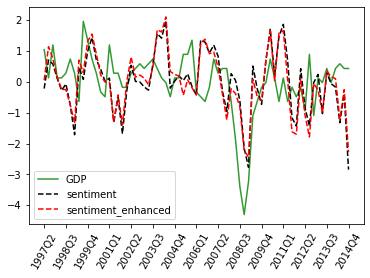

In [56]:
scaler = StandardScaler()
ticks = np.arange(0, df.shape[0], 5)
labs = np.array([str(x)+'Q'+str(y) for x,y in zip(df['year'],df['quarter'])])
labs = labs[ticks]

fig, ax = plt.subplots()
ax.plot(scaler.fit_transform(df.gdp_growth.values.reshape(-1, 1)).flatten(), 
        label='GDP', c='green', alpha=0.8)
ax.plot(scaler.fit_transform(df.sentiment.values.reshape(-1, 1)).flatten(), 
        label='sentiment', linestyle='dashed', c='black')
ax.plot(scaler.fit_transform(df.sentiment_enhanced.values.reshape(-1, 1)).flatten(), 
        label='sentiment_enhanced', linestyle='dashed', c='red')


ax.set_xticks(ticks)
ax.set_xticklabels(labs, rotation=60)
ax.legend()

plt.show()

# 4. Preprocessing with standard packages

We have built the ```RawDocs``` class making use of renowned packages commonly employed for performing text preprocessing in Python. We believe this class is a user-friendly tool for approaching text preprocessing, that allows as well for flexibility and customisation.

On the other hand, we deem it important to familiarise with the standard methods and packages the class is built upon. To this end, we will go through a simplified version of the preprocessing steps we have performed above, making use of standard packages only. We will compute again the sentiment index and see that in our simple example we obtain aligned results.

In [57]:
# lower case via the lower() built-in method
docs = [s.lower() for s in data.minutes]

In [58]:
# split contractions with the contraction package
docs = list(map(lambda x: contractions.fix(x), docs))

In [59]:
# tokenize with the spaCy tokenizer
def spacy_tokenizer_standard(sent):
    sent = nlp_standard.tokenizer(sent)
    tokens = [t.text for t in sent]
    return tokens

tokens = list(map(spacy_tokenizer_standard, docs))

In [60]:
# remove non-ascii characters via unicodedata package
def remove_non_ascii(tokens):
    tokens = [unicodedata.normalize('NFKD', t).encode('ascii', 'ignore').decode('utf-8', 'ignore') 
                        for t in tokens]
    return tokens

tokens = list(map(remove_non_ascii, tokens))

In [61]:
# remove short tokens via simple list comprehension
def remove_short(tokens, length=2):
    return [t for t in tokens if t != '' and len(t) > length] 
tokens = list(map(remove_short, tokens))

In [62]:
# remove punctuation via regularised expressions
def remove_punctuation(tokens, punctuation):            
    regex = re.compile('[%s]' % re.escape(punctuation))
    tokens = [regex.sub('', t) for t in tokens]
    return tokens

tokens = list(map(lambda x: remove_punctuation(x,punctuation), tokens))


In [63]:
# remove stopwords via simple list comprehension
def remove_stopwords(tokens, stopwords):
    return [t for t in tokens if t not in stopwords]
tokens = list(map(lambda x: 
                  remove_stopwords(x, stopwords=preprocess_data.stp_long),
                  tokens))


In [64]:
# stem via standard nltk Snowball Stemmer
def stem(tokens):
    return [stemmer.stem(t) if "-" not in t else t for t in tokens]

stems = list(map(stem, tokens))

In [65]:
# lemmatize with standard spaCy lemmatizer
def lemmatize_sent(sent):
    sent = ' '.join(sent)
    doc = nlp_standard(sent)
    lemmas = [token.lemma_ if token.lemma_ != '-PRON-' else token.text for token in doc]
    return lemmas

lemmas = list(map(lemmatize_sent, tokens))


In [66]:
# vectorizer with sklearn vectorizer, that allows as well for dropping most/least frequent items
def dummy(doc):
    return doc
vectorizer = TfidfVectorizer(use_idf=False, norm=None, 
                             min_df=3, tokenizer=dummy, preprocessor=dummy) 
df_matrix = vectorizer.fit_transform(stems).toarray()
vocabulary = vectorizer.vocabulary_


We can use the so-obtained stems to build the sentiment index as we did in the previous section, and compare with our previous metrics.

In [67]:
pos_ixs = [v for k,v in vocabulary.items() if k in pos_stems]
neg_ixs = [v for k,v in vocabulary.items() if k in neg_stems]

In [68]:
pos_counts = np.take(df_matrix, pos_ixs, axis=1)
pos_counts = pos_counts.sum(axis=1)

neg_counts = np.take(df_matrix, neg_ixs, axis=1)
neg_counts = neg_counts.sum(axis=1)

In [69]:
data['pos_counts_standard'] = pos_counts
data['neg_counts_standard'] = neg_counts

In [70]:
# aggregate to year-quarter level
data_agg = data.groupby(['year', 'quarter']).sum().reset_index()
data_agg.head()

,year,quarter,length,pos_counts,neg_counts,pos_counts_standard,neg_counts_standard
0,1997,2,3464,28.0,18.0,28.0,18.0
1,1997,3,19016,245.0,93.0,246.0,95.0
2,1997,4,21023,244.0,113.0,244.0,116.0
3,1998,1,25790,264.0,162.0,267.0,166.0
4,1998,2,29387,255.0,187.0,258.0,192.0


In [71]:
# compute sentiment at year-quarter level
data_agg['sentiment_enhanced'] = (data_agg.pos_counts - data_agg.neg_counts)/(data_agg.pos_counts + data_agg.neg_counts)
data_agg['sentiment_enhanced_standard'] = (data_agg.pos_counts_standard - data_agg.neg_counts_standard)/(data_agg.pos_counts_standard + data_agg.neg_counts_standard)

data_agg = data_agg[['year', 'quarter', 'sentiment_enhanced', 'sentiment_enhanced_standard']].copy()
data_agg.head()

,year,quarter,sentiment_enhanced,sentiment_enhanced_standard
0,1997,2,0.217391,0.217391
1,1997,3,0.449704,0.442815
2,1997,4,0.366947,0.355556
3,1998,1,0.239437,0.233256
4,1998,2,0.153846,0.146667


In [72]:
# merge to gdp data
df = data_agg.merge(gdp_df, how='left', on=['year', 'quarter']).copy()

Looking at correlations, we see that the new sentiment index shows a correlation with GDP which is only slightly lower than the one obtained via the RawDocs class.

In [73]:
print(df[['gdp_growth', 'sentiment', 'sentiment_enhanced', 'sentiment_enhanced_standard']].corr())

                             gdp_growth  sentiment  sentiment_enhanced  \
gdp_growth                     1.000000   0.286951            0.330013   
sentiment                      0.286951   1.000000            0.965835   
sentiment_enhanced             0.330013   0.965835            1.000000   
sentiment_enhanced_standard    0.329447   0.967381            0.999133   

                             sentiment_enhanced_standard  
gdp_growth                                      0.329447  
sentiment                                       0.967381  
sentiment_enhanced                              0.999133  
sentiment_enhanced_standard                     1.000000  


Below we plot standardized series for growth and sentiment metrics.

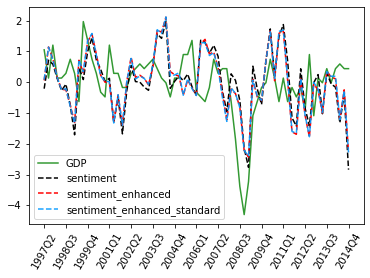

In [74]:
scaler = StandardScaler()
ticks = np.arange(0, df.shape[0], 5)
labs = np.array([str(x)+'Q'+str(y) for x,y in zip(df['year'],df['quarter'])])
labs = labs[ticks]

fig, ax = plt.subplots()
ax.plot(scaler.fit_transform(df.gdp_growth.values.reshape(-1, 1)).flatten(), 
        label='GDP', c='green', alpha=0.8)
ax.plot(scaler.fit_transform(df.sentiment.values.reshape(-1, 1)).flatten(), 
        label='sentiment', linestyle='dashed', c='black')
ax.plot(scaler.fit_transform(df.sentiment_enhanced.values.reshape(-1, 1)).flatten(), 
        label='sentiment_enhanced', linestyle='dashed', c='red')
ax.plot(scaler.fit_transform(df.sentiment_enhanced_standard.values.reshape(-1, 1)).flatten(), 
        label='sentiment_enhanced_standard', linestyle='dashed', c='#0099ff', alpha=0.9)


ax.set_xticks(ticks)
ax.set_xticklabels(labs, rotation=60)
ax.legend()

plt.show()